# Klasifikacija mina i kamenja u sonar datasetu 

### Autori: Alen Andrašek, Monika Majstorović, Luka Valenta 

Ovaj notebook napravljen je za potrebe kolegija Strojno učenje na PMF-u Sveučilišta u Zagrebu kao realizacija projektnog zadatka u akademskoj godini 2017./2018. 

Mentori:
- Tomislav Šmuc, prof.
- Tomislav Lipić, asist.
- Matija Piškorec, asist.

Cilj ovog notebooka jest pokazati primjer metodologije pri odabiru modela, obradi podataka i općenito realizaciji projekta. Bit će koncipiran kao tutorijal za provedbu projekta "od nule" (tj. počevši od dataseta).

Dataset kojeg koristimo naziva se Connectionist Bench (Sonar, Mines vs. Rocks) Data Set (skraćeno: sonar dataset) i skinut je s UCI repozitorija za strojno učenje.

###  1. O datasetu

Prvo pitanje koje si postavljamo kada pred sobom imamo dataset jest: koji problem rješavamo pomoću ovog dataseta?

U opisu sonar dataseta dostupnom na [ref] saznajemo da je za svaki uzorak u datasetu poznato radi li se o mini ili kamenu te da je zadatak klasifikacija podataka u te dvije skupine.
Dakle, radi se o **nadziranom učenju** i problemu **binarne klasifikacije**.

Kako izgleda dataset?

Iz [ref] također saznajemo da dataset sadrži 208 podataka. Svaki od njih ima 60 značajki čije su vrijednosti između 0.0 i 1.0 te oznaku klase 'R' ili 'M' ovisno o tome pripada li podatak kamenu ili mini. Ukupno ima 111 podataka koji pripadaju minama i 97 koji pripadaju kamenju. Nema vrijednosti koje nedostaju.

Pokažimo kako bismo to ispitali koristeći pandas:

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Učitamo dataset i dodijelimo imena stupcima

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"

colNames = []
for i in range(60):
    colNames.append(i)
colNames.append("Class")

sonar = pd.read_csv(url,names=colNames,header=None)
sonar.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [8]:
sonar.shape  # Dataframe ima 208 redaka i 61 stupac.

(208, 61)

In [9]:
sonar.dtypes  # Tipovi podataka u dataframeu.

0        float64
1        float64
2        float64
3        float64
4        float64
5        float64
6        float64
7        float64
8        float64
9        float64
10       float64
11       float64
12       float64
13       float64
14       float64
15       float64
16       float64
17       float64
18       float64
19       float64
20       float64
21       float64
22       float64
23       float64
24       float64
25       float64
26       float64
27       float64
28       float64
29       float64
          ...   
31       float64
32       float64
33       float64
34       float64
35       float64
36       float64
37       float64
38       float64
39       float64
40       float64
41       float64
42       float64
43       float64
44       float64
45       float64
46       float64
47       float64
48       float64
49       float64
50       float64
51       float64
52       float64
53       float64
54       float64
55       float64
56       float64
57       float64
58       float

In [10]:
sonar.groupby('Class').size()  # Želimo saznati koliko ima podataka određene klase.

Class
M    111
R     97
dtype: int64

In [11]:
sonar.isnull().any().any()  # Ima li vrijednosti koje nedostaju?

False

Sonar dataset je mali. Kod malih datasetova veći problem nego kod velikih datasetova mogu prestavljati:
-  vrijednosti koje nedostaju
-  buka
-  overfitting

Više o načinu pristupa malim datasetovima u strojnom učenju pročitajte u članku [ref].

Već smo pokazali da nema vrijednosti koje nedostaju u sonar datasetu.

Pretpostavljamo da je buka u datasetu minimalna zbog načina prikupljanja i obrade podataka prije nego što su ušli u dataset. Naime, podaci su skupljeni tako što su na pjeskovito morsko dno stavljeni metalni cilindar i kamenje otprilike
cilindričnog oblika, oboje duljine oko 1.52 m (5 ft) te je pomoću sonara emitiran signal. Jeka je prikupljena s udaljenosti 10 m te iz kuteva raspona do 90° za cilindar i raspona do 180° za kamen. **Od 1200 primljenih zvukova, odabrano ih je 208 koji su imali omjer šuma i signala između 4 dB i 15 dB.** Daljnjom spektralnom analizom signala te normalizacijom dobivenih podataka svaki od 208 signala predstavljen je konačno 60-dimenzionalnim vektorom u kojem svaka komponenta poprima vrijednosti između 0.0 i 1.0.

Za rješavanje problema overfittinga preporučuje se odabir jednostavnijih modela poput logističke regresije, k-Nearest Neighbours (k-NN), Support Vector Machine (SVM), Random Forest (dodati još, ne sjećam se). 

Mi smo odabrali SVM i k-NN. Njihov performans na kraju ćemo usporediti.



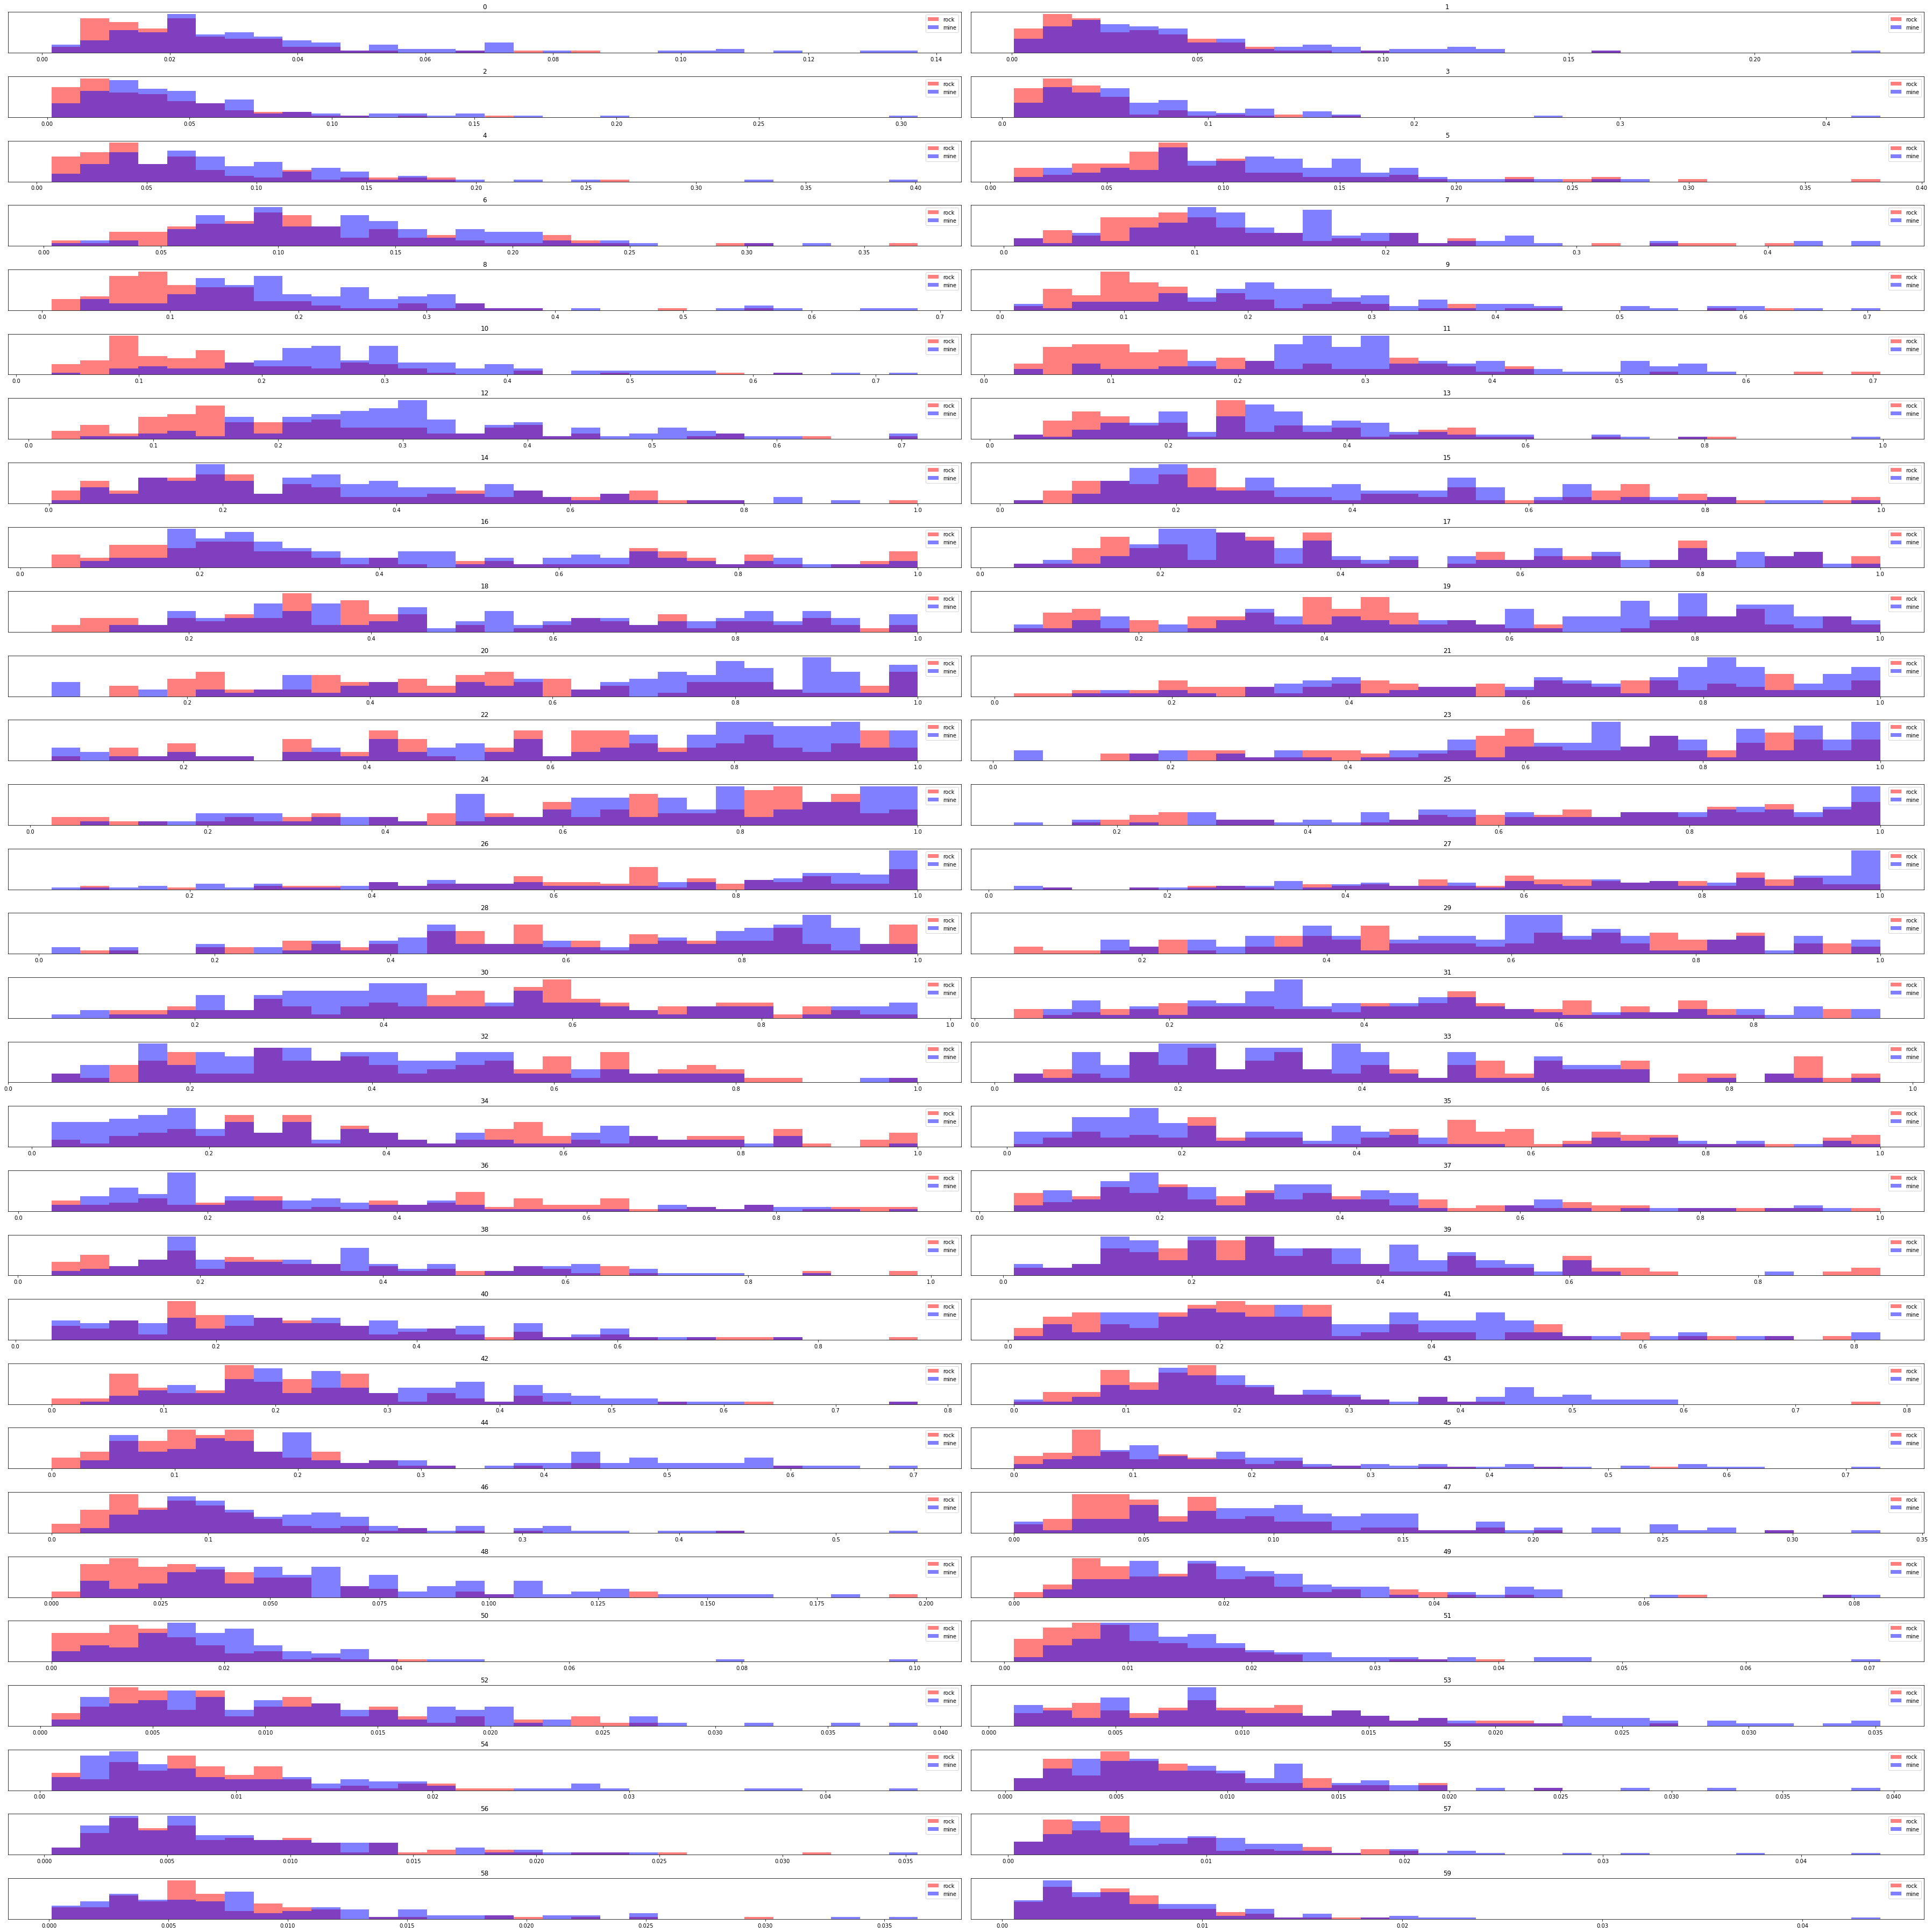

In [12]:
# Koreliranost klasa
rock = sonar.loc[ sonar['Class'] == 'R', : ]
mine = sonar.loc[ sonar['Class'] == 'M', : ]

fig, axes = plt.subplots(30, 2, figsize=(50,50))
ax = axes.ravel() # axes are 2-dimensional so we unfold them
for i in range(60):
    _, bins = np.histogram(sonar.iloc[:,i], bins=30)
    ax[i].hist(rock.iloc[:,i], bins=bins, color='r', alpha=.5, label='rock')
    ax[i].hist(mine.iloc[:,i], bins=bins, color='b', alpha=.5, label='mine')
    ax[i].set_title(sonar.columns.values[i])
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right')
fig.tight_layout();

Nećemo vršiti standardizaciju podataka prije PCA jer su nam podaci istog tipa i u istoj mjernoj jedinici.
[ref = https://www.researchgate.net/post/What_is_the_best_way_to_scale_parameters_before_running_a_Principal_Component_Analysis_PCA]

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [14]:
sonar_y = [] # target array (niz čiji elementi govore je li odgovarajući element tog indexa u datasetu sonar R ili M)
for i in range(97):
    sonar_y.append(0) # 0 označavaju R
for i in range(111):
    sonar_y.append(1) # 1 označavaju M
sonar_y = np.array(sonar_y)

sonar_bez_Class = sonar.drop('Class', axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)

# sonar_y i sonar_X moraju biti np.array jer fja split prima samo objekte tog tipa

In [42]:
# Podjela u skupove za krosvalidaciju

random_state = 164981614
# fiksiranje broja random state omogućuje da svaki put kada opet runamo ovaj kod, dobijemo istu podjelu na subsetove
# ovaj broj kojim fiksiramo odabran je nasumično

rskf = RepeatedStratifiedKFold(n_splits=13, n_repeats=1, random_state=random_state)

oCV_X_train, oCV_X_test, oCV_y_train, oCV_y_test = [], [], [], []
# možda će ih trebati pretvoriti u numpy array kasnije, ne znam

for train_index, test_index in rskf.split(sonar_X, sonar_y):
    oCV_X_train.append(sonar_X[train_index])
    oCV_X_test.append(sonar_X[test_index])
    oCV_y_train.append(sonar_y[train_index])
    oCV_y_test.append(sonar_y[test_index])

In [40]:
from sklearn.decomposition import PCA
pca = PCA(.95) #  Zadržat ćemo 95% varijance (95% se inače uzima, mi se možemo dogovoriti i za manji broj)
brojKomponenti = [] # Usput ćemo i bilježiti koliko komponenti smo uzeli za svaki skup, tj. kolika nam je sada dimenz.

oCV_X_train_, oCV_X_test_=[], [] # Nizovi koji će sadržavati train i test setove nakon PCA

for i in range(13):
    pca.fit(oCV_X_train[i]) # Napravimo PCA samo na train setu i onda pomoću tih principal comp. transformiramo i test set
    brojKomponenti.append(pca.n_components_)
    oCV_X_train_.append(pca.transform(oCV_X_train[i]))
    oCV_X_test_.append(pca.transform(oCV_X_test[i]))
    
brojKomponenti

[17, 17, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16]